In [1]:
import nibabel as nb
import numpy as np
import pandas as pd 
from nilearn import plotting
from fragmenter import Fragment
from fragmenter import adjacency

/Applications/anaconda2/envs/python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda2/envs/python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


This is a simple demo of the parcellation fragmenter, from simple use to some benchmarks. The first step is to load a template surface (in this case, the inflated fsaverage).

In [2]:
testSurface = nb.freesurfer.read_geometry(
    '/Users/Claudio/Desktop/parcellation_fragmenter-modularization/freesurfer/fsaverage/surf/rh.inflated'
)

Surfaces are a 2D triangular mesh, so that each data-containing vertex is tied to 2 neighbors by a triangle. When loading it, you get a tuple of two arrays: the coordinates of each vertex and the vertex's direct neighbors (faces).

In [3]:
testSurface

(array([[ -6.77207661,  10.74224281,  63.36345291],
        [  7.45265865, -43.94926453,  43.67302322],
        [ 40.67627335,   8.6865921 ,  15.46871376],
        ...,
        [ 20.50901985,  -7.89210987, -66.16957092],
        [ 20.29653549,  -8.46869278, -65.95698547],
        [ 20.08860397,  -8.99943542, -65.75714111]]),
 array([[     0,  40964,  40962],
        [     0,  40962,  40965],
        [     0,  40965,  40967],
        ...,
        [163841, 160926,  39990],
        [163113, 160926, 163841],
        [163113,     11, 160926]], dtype=int32))

The fsaverage mesh is composed of ~164k vertices, which we can confirm here.

In [4]:
print('The surface has %d vertices.' % np.shape(testSurface[1])[0])

The surface has 327680 vertices.


In order to fragment a surface, we first create a `Fragment` object that takes in the desired number of clusters, and whether you want to use pretty colors (T/F). In this case, we will run a simple 10 parcel example.

In [5]:
testFragment = Fragment.Fragment(n_clusters=10)

Once the object is defined, you can check that the number of clusters is right.

In [6]:
testFragment

Now we are ready to fit the number of clusters onto the provided surface. Coordinates and vertices are provided separately (meaning that you could just cluster custom, non-cortical meshes). The following example 

In [7]:
testFragment.fit(vertices = testSurface[0], faces=testSurface[1], method = 'k_means')

This will add an attribute to `testFragment` called `label_`, which is the parcel label associated with each vertex. We can confirm this by checking that length of the resulting vector is equal to the number of vertices in fsaverage.

In [8]:
nVerts = np.size(testFragment.label_)
nVerts

163842

And we can see that the number of labels produced is equal to our desired number (10)

In [9]:
np.unique(testFragment.label_)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

And now we can plot the 10 parcels onto a surface (**FIX THIS SO WE CAN USE VIEW_SURF INSTEAD**).

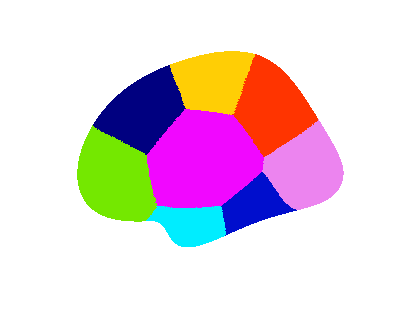

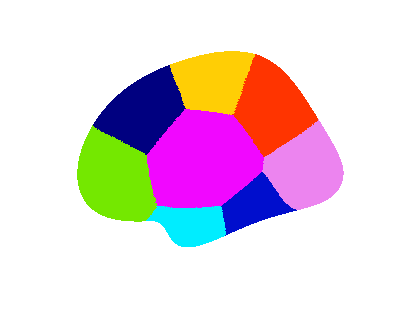

In [10]:
plotting.plot_surf_roi(list(testSurface), testFragment.label_)

**This part is just for the probability permutation assignment**

In [16]:
def probabilityPerm(surface, fragmentObj):
    # This function will slightly perturb one of the computed parcellations for permutation purposes
    # The surface argument requires a tuple with 2 arrays (coordinates and faces)
    # fragmentObj is the fitted fragmented object (make sure that it has the 'label_' attribute)
    # The idea is that vertices at the edge of each parcel will be re-assigned with probability proportional 
    # to the number of its neighbors from different parcels.
    # It returns a vector with a label for each vertex
    
    # Get the neighbors of each vertex
    A = adjacency.SurfaceAdjacency(surface[0], surface[1])
    A.generate() # A.adj to get the adjacency list
    
    # Get the new set of labels for all vertices
    nVerts = np.size(fragmentObj.label_)
    newLbls = []
    for vertex in np.arange(nVerts):
        labels = fragmentObj.label_[A.adj[vertex]] # Assign the original parcel labels to the vertex's neighbors
        newLbls.append(np.random.choice(labels)) # Reassign a label

    return newLbls

In [17]:
test = probabilityPerm(testSurface, testFragment)

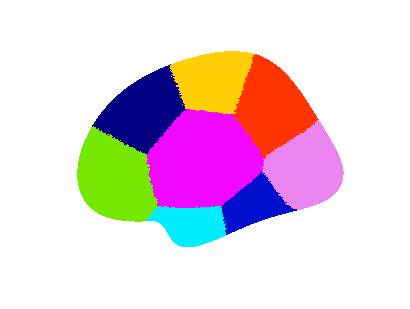

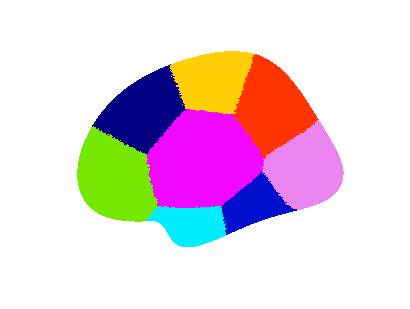

In [18]:
plotting.plot_surf_roi(list(testSurface), np.asarray(test))

In [21]:
from sklearn import metrics

metrics.adjusted_rand_score(testFragment.label_, test)

0.9768698767383124

In [22]:
metrics.jaccard_similarity_score(testFragment.label_, test)

0.98939221933326

In [24]:
(testFragment.label_ == test).mean()

0.98939221933326